# Capstone Project - Which Shoe is the Best for You?

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups
- Recommender

In [121]:
# Import libraries
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import ast
from os import listdir

% matplotlib inline

**Testing one website and finding appropriate keys**

Then run again on page 2.

In [122]:
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()

# print json_res['Products'][0]['shortDescription']
# print json_res['Products'][0]['retailPrice']

In [123]:
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()

print json_res['Products'][0]['shortDescription']
print json_res['Products'][0]['retailPrice']

Adidas-Yeezy-Boost-350-V2-Core-Black-White
220


In [124]:
json_res['Products'][0]['market']

{u'absChangePercentage': 0.048921,
 u'annualHigh': 1500,
 u'annualLow': 401,
 u'averageDeadstockPrice': 562,
 u'averageDeadstockPriceRank': 98,
 u'changePercentage': -0.048921,
 u'changeValue': -34,
 u'createdAt': u'2016-10-20T18:00:08+00:00',
 u'deadstockRangeHigh': 698,
 u'deadstockRangeLow': 624,
 u'deadstockSold': 4981,
 u'deadstockSoldRank': 70,
 u'highestBid': 825,
 u'lastHighestBidTime': 1498532269,
 u'lastLowestAskTime': 1498278421,
 u'lastSale': 661,
 u'lastSaleDate': u'2017-06-27T16:24:33+00:00',
 u'lowestAsk': 650,
 u'pricePremium': 2.005,
 u'pricePremiumRank': 7,
 u'productId': 0,
 u'productUuid': u'f3f603f0-e1c0-48d1-9aad-206b00351e1b',
 u'salesLast72Hours': 32,
 u'salesLastPeriod': 0,
 u'salesThisPeriod': 32,
 u'skuUuid': None,
 u'updatedAt': 1498580950,
 u'volatility': 0.055317}

### Functions to run for loop to scrape website

First function scrapes the web for an amount of pages (default 50). It will save the raw data as a csv as well. The second function will then clean the dataframe by taking out the unused columns.

In [125]:
def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. 
    And will save into a new file.'''
    
    # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    
    csv_maker(df)
    
    return df

In [126]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information.
    Then reset the index since we are getting repeated indices'''
    
    # Market DataFrame. If scraping, comes in ready form
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
    
    # Drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank',
        'salesThisPeriod'], axis=1)
    
    # Remember title = shoe + name

    # Reset the index, since we are getting repeated indices
    cleanest_dataframe.reset_index(drop=True, inplace=True)
    
    return cleanest_dataframe

In [127]:
scraped_shoe = shoe_scraper()

In [128]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by
    removing duplicates, removing first column (Unnamed: 0) to be ready for
    clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    return df

In [129]:
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

In [130]:
shoe = shoe[shoe.retailPrice.notnull()]
shoe.shape

(1649, 25)

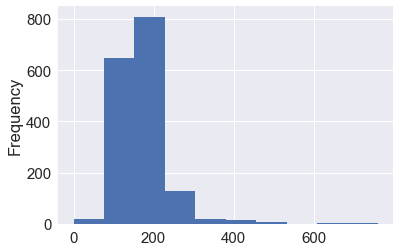

In [131]:
shoe.retailPrice.plot(kind='hist')

In [143]:
shoe[shoe.highestBid > 5000][['shoe', 'colorway', 'name', 'highestBid', 'year']]

,shoe,colorway,name,highestBid,year
133,Adidas Iniki Runner,Off White/Collegiate Royal/Core Red,Pride Of The 70s USA,20002,2017.0
485,Jordan 7 Retro,White/Metallic Gold Coin-Deep Royal Blue-Fire ...,Tinker Alternate,7000,2016.0


In [133]:
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year']]

,shoe,colorway,name,retailPrice,year
898,Reebok Instapump Fury,White/Multi-Color,Vetements Doodle,760.0,2017.0


In [134]:
shoe.head(2)

,brand,category,colorway,name,releaseDate,retailPrice,shoe,title,year,absChangePercentage,...,createdAt,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lastSaleDate,lowestAsk,salesLast72Hours,volatility
0,Adidas,adidas Yeezy,White/Core Black/Red,Zebra,2017-02-25 23:59:59,220.0,Adidas Yeezy Boost 350 V2,Adidas Yeezy Boost 350 V2 Zebra,2017.0,0.294872,...,2015-10-26T20:03:03+00:00,139,81,20,95,110,2017-06-16T17:51:52+00:00,119,4,0.267071
1,Adidas,adidas Yeezy,Core White/Core White/Core White,Calabasas Core White,2017-03-28 23:59:59,120.0,Adidas Yeezy Powerphase,Adidas Yeezy Powerphase Calabasas Core White,2017.0,0.392308,...,2016-12-06T18:37:51+00:00,202,160,11,130,181,2017-06-16T17:35:07+00:00,139,3,0.116816


In [135]:
shoe.brand.value_counts()

Nike            578
Jordan          563
Adidas          410
Asics            30
Vans             19
Reebok           15
New Balance      11
Diadora           6
Puma              6
Under Armour      5
Saucony           4
Converse          1
Clarks            1
Name: brand, dtype: int64

In [136]:
tops = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]

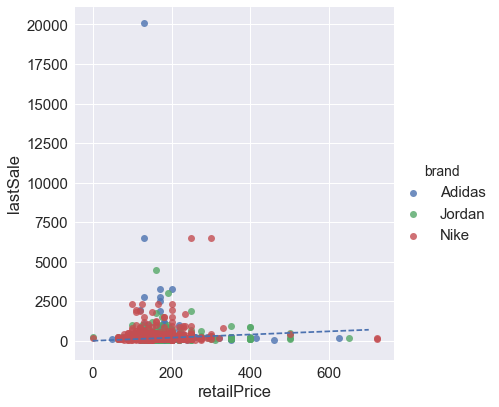

In [137]:
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='lastSale', data=tops, hue='brand', fit_reg=False, size=6)
plt.plot(np.linspace(0,700,700), np.linspace(0,700,700), linestyle='--')
plt.show()

KeyboardInterrupt: 

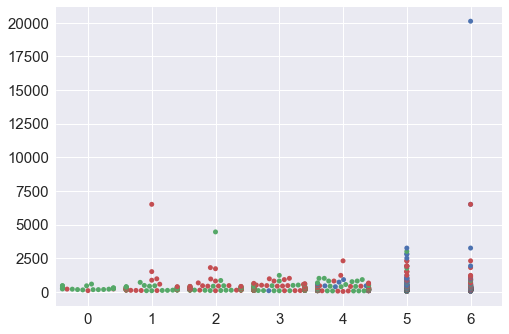

In [138]:
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2010], hue='brand')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Adidas didn't come into the market until 2015. Let's look more closely
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2014], hue='brand')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Adidas boost's came out in January 2015 along with Yeezy's in February of 2015
tops[(tops.brand=='Adidas') & (tops.shoe.str.contains('boost', case=False))].shape

In [ ]:
# Adidas and Nike Yeezy's
tops[tops.shoe.str.contains('yeezy',case=False)].shape

In [ ]:
# Did Adidas increase market share (on StockX)?
sub_tops = tops[tops.year>2010].groupby(['year', 'brand'])['brand'].count().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T
sub_tops

In [ ]:
sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
tops.iloc[:,7:]